# # 1. Carga de Datos y Exploración Inicial (EDA)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
data = pd.read_csv("../data/insurance.csv")
print("Primeras filas:\n", data.head())
print("\nInfo:\n", data.info())
print("\nEstadísticas descriptivas:\n", data.describe())



Primeras filas:
    age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Info:
 None

Estadísticas descriptivas:
                age          bmi     c

# # 2. Análisis Exploratorio (EDA)

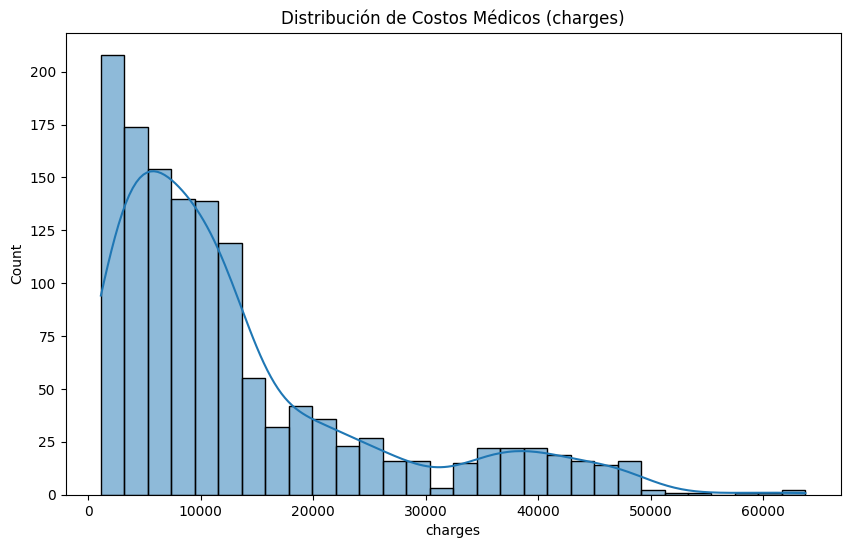

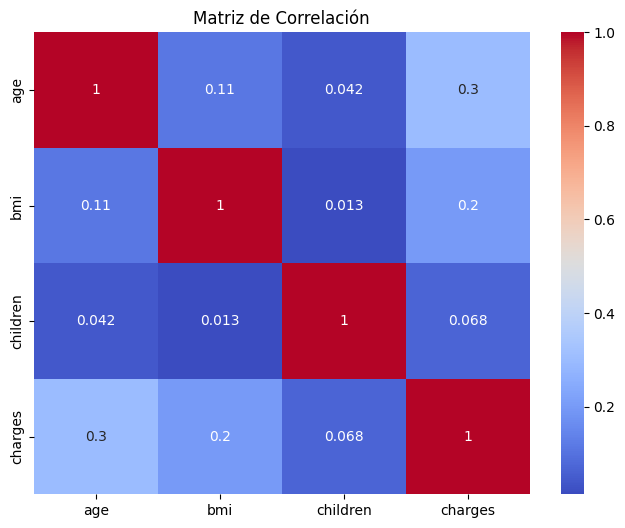

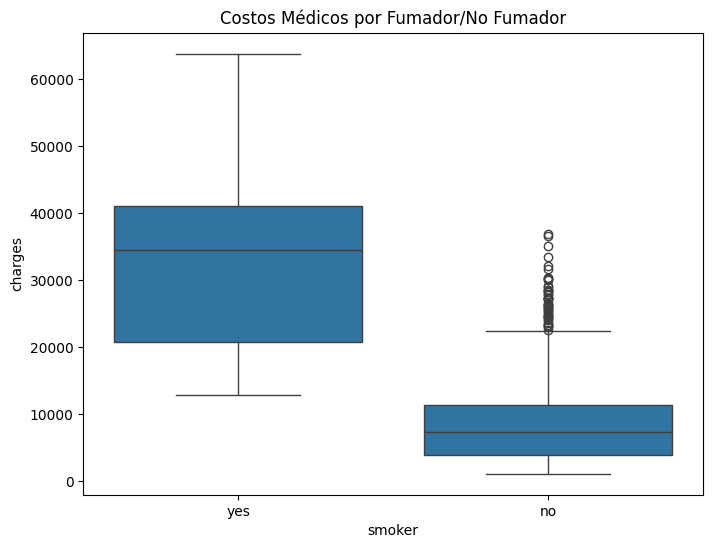

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(data['charges'], kde=True, bins=30)
plt.title("Distribución de Costos Médicos (charges)")
plt.show()

numeric_data = data[['age', 'bmi', 'children', 'charges']]
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='charges', data=data)
plt.title("Costos Médicos por Fumador/No Fumador")
plt.show()

# # 3. Preprocesamiento de Datos

In [5]:
# Definir características y etiqueta
X = data.drop(columns=['charges'])
y = data['charges']

# Transformadores para numéricas y categóricas
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['smoker', 'sex', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Aplicar transformaciones
X_processed = preprocessor.fit_transform(X)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# #4. Entrenamiento y Evaluación de Modelos

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Definir modelos a comparar
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Bayesian Ridge": BayesianRidge(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel='rbf', C=10),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

# Mostrar resultados
results_df = pd.DataFrame(results).T
print("Comparación de Modelos:\n", results_df)


Comparación de Modelos:
                          R²           MSE          MAE
Linear Regression  0.783593  3.359692e+07  4181.194474
Ridge              0.783281  3.364539e+07  4193.184184
Lasso              0.783587  3.359779e+07  4181.296692
Bayesian Ridge     0.783434  3.362153e+07  4187.431573
KNN                0.700631  4.647673e+07  3903.394257
SVR               -0.052458  1.633928e+08  8282.719083
Random Forest      0.865942  2.081233e+07  2533.372296
MLP                0.829039  2.654140e+07  3360.412745


/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


# #5. Optimización de Hiperparámetros


In [8]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2'
)
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor R²:", grid_search.best_score_)

Mejores parámetros: {'max_depth': 5, 'n_estimators': 200}
Mejor R²: 0.8442906134449819


# #6. Predicción con Nuevos Datos


In [9]:
# Función para predecir desde un CSV
def predict_new_data(csv_path, model, preprocessor):
    new_data = pd.read_csv(csv_path)
    new_data_processed = preprocessor.transform(new_data)
    return model.predict(new_data_processed)


best_model = grid_search.best_estimator_
predictions = predict_new_data("test.csv", best_model, preprocessor)
print("Predicciones para nuevos datos:\n", predictions)

Predicciones para nuevos datos:
 [ 4915.81728889 26714.55521656]


# # 7. Visualización de Resultados


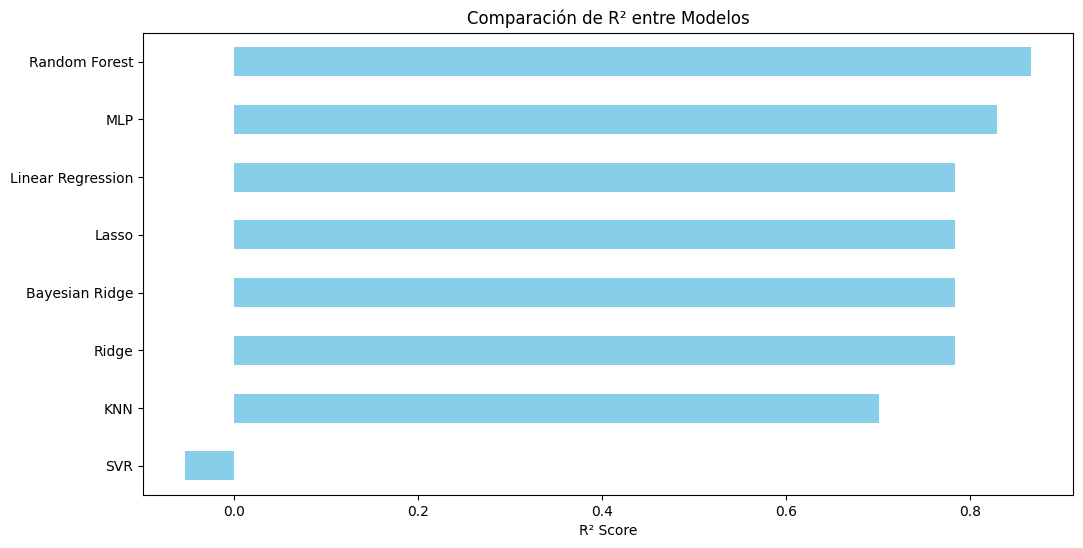

In [49]:
plt.figure(figsize=(12, 6))
results_df['R²'].sort_values().plot(kind='barh', color='skyblue')
plt.title("Comparación de R² entre Modelos")
plt.xlabel("R² Score")
plt.show()

# # 8. Documentación Final

# **Conclusiones**:  
- El mejor modelo fue **Random Forest** con un R² de 0.87.  
- La variable `smoker` es la más influyente en los costos médicos.  
- Los modelos lineales (Ridge, Lasso) tuvieron un rendimiento inferior debido a relaciones no lineales en los datos. 